In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot
from utilities import generate_connection_matrix, sample_uniform_noise, generate_dataset, sample_from_disjoint_interval

In [ ]:
def perturb_adjacency_matrix(matrix, n=1, mode='both'):
    """
    Perturbs a weighted adjacency matrix by adding/removing edges,
    preserving causal order (i.e., j < i for edge j → i).

    Parameters:
    - matrix: np.ndarray, square weighted adjacency matrix
    - n: number of edges to add/remove
    - mode: 'add', 'remove', or 'both'
    - weight_range: tuple, range of weights to assign when adding edges

    Returns:
    - new_matrix: np.ndarray, perturbed matrix
    """

    new_matrix = matrix.copy()
    num_nodes = new_matrix.shape[0]
    
    # change all non-zero weights (j < i) to have matrix with same causal order but different coefficients
    '''for i in range(num_nodes):
        for j in range(i):  # Ensure j < i
            if new_matrix[i, j] != 0:
                new_matrix[i, j] = sample_from_disjoint_interval(1)[0]'''

    # Collect removable and addable edges
    removable_edges = [(i, j) for i in range(num_nodes) for j in range(i) if new_matrix[i, j] != 0]
    addable_edges = [(i, j) for i in range(num_nodes) for j in range(i) if new_matrix[i, j] == 0]
    
    if mode in ['remove', 'both']:
        to_remove = random.sample(removable_edges, min(n, len(removable_edges)))
        for i, j in to_remove:
            new_matrix[i, j] = 0.0

    if mode in ['add', 'both']:
        to_add = random.sample(addable_edges, min(n, len(addable_edges)))
        for i, j in to_add:
            weight = sample_from_disjoint_interval(1)[0]
            new_matrix[i, j] = weight

    return new_matrix


In [176]:
import random
import networkx as nx

def perturb_adjacency_matrix(matrix, n=1, mode='both'):
    """
    Perturbs a weighted adjacency matrix by changing existing weights and 
    optionally adding/removing edges, preserving causal order (j < i).

    Parameters:
    - matrix: np.ndarray, square weighted adjacency matrix
    - n: int, number of edges to add/remove
    - mode: str, one of 'add', 'remove', or 'both'

    Returns:
    - new_matrix: np.ndarray, perturbed matrix
    """
    new_matrix = matrix.copy()
    num_nodes = new_matrix.shape[0]
    
    # Get lower triangle indices (j < i)
    i, j = np.tril_indices(num_nodes, k=-1)

    # Reassign all existing weights (preserve structure but change values)
    mask = new_matrix[i, j] != 0
    new_weights = sample_from_disjoint_interval(mask.sum())
    new_matrix[i[mask], j[mask]] = new_weights

    # Get current removable and addable edges
    removable_edges = list(zip(i[mask], j[mask]))
    addable_edges = list(zip(i[~mask], j[~mask]))

    # Remove edges
    if mode in ['remove', 'both']:
        to_remove = random.sample(removable_edges, min(n, len(removable_edges)))
        rem_i, rem_j = zip(*to_remove) if to_remove else ([], [])
        new_matrix[rem_i, rem_j] = 0.0

    # Add edges
    if mode in ['add', 'both']:
        to_add = random.sample(addable_edges, min(n, len(addable_edges)))
        add_i, add_j = zip(*to_add) if to_add else ([], [])
        new_weights = sample_from_disjoint_interval(len(to_add)) if to_add else []
        new_matrix[add_i, add_j] = new_weights

    return new_matrix




def get_causal_order(matrix):
    G = nx.DiGraph()
    num_nodes = matrix.shape[0]

    # Add edges from matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            if matrix[i, j] != 0:
                G.add_edge(j, i)  # edge from parent j to child i

    # Compute topological sort
    try:
        causal_order = list(nx.topological_sort(G))
        return causal_order
    except nx.NetworkXUnfeasible:
        raise ValueError("The graph contains cycles and is not a DAG.")

In [3]:
%load_ext autoreload
%autoreload 2

In [229]:
def simulate_multigroup_data(p, s, c, PERT, shared_permutation=True, seed=None):
    rng = np.random.default_rng(seed)
    B = generate_connection_matrix(p, s)
    perm = None
    datasets = []
    matrices = []
    #sample_sizes = [rng.integers(int(10_000), int(15_000)) for _ in range(C)] #change 10_000 and 15_000 with 1.2*p and 2.5*p
    sample_size = int(rng.uniform(10_000, 15_000))
    for g in range(c):
        n_perturb = int(np.count_nonzero(B) * PERT)
        Bc = perturb_adjacency_matrix(B, n_perturb, "both")
        variances = rng.uniform(1, 3, size=p)
        E = sample_uniform_noise(sample_size, p, variances)
        X, _, perm = generate_dataset(E, Bc, sample_size, permutation=perm 
        if shared_permutation else None)
        datasets.append(X)
        matrices.append(Bc)
    
    return datasets, matrices, perm

In [205]:
from sklearn.metrics import mean_squared_error
def average_squared_error(true_B, est_B):
    # Flatten matrices and compute MSE
    return mean_squared_error(true_B.flatten(), est_B.flatten())

def invert_permutation(B, perm):
    inverse_perm = np.argsort(perm)
    B_perm_inverted = B[inverse_perm, :][:, inverse_perm]
    return B_perm_inverted

def compute_rescaling_matrix(adj_matrix: np.ndarray, X: pd.DataFrame) -> np.ndarray:
    """
    Compute the rescaling matrix R such that:
    B = R * B_tilde

    Parameters:
    - adj_matrix: np.ndarray, shape (n, n)
        Adjacency matrix (non-zero entries represent edges i → j)
    - X: pd.DataFrame, shape (n_samples, n_variables)
        Original (non-normalized) data

    Returns:
    - R: np.ndarray, shape (n, n)
        Rescaling matrix
    """
    sums = X.sum().values
    n = adj_matrix.shape[0]
    R = np.zeros((n, n))
    for i in range(n):         # row: target node
        for j in range(n):     # col: source node
            if adj_matrix[i, j] != 0:
                R[i, j] = sums[i] / sums[j]
    return R

def normalize_by_column_sum(X):
    """
    Normalize each column so that the sum of each column is 1.
    
    Parameters:
    - X: np.ndarray, shape (n_rows, n_columns)
    
    Returns:
    - X_norm: np.ndarray, same shape as X
    """
    col_sum = X.sum(axis=0)
    col_sum[col_sum == 0] = 1  # Avoid division by zero
    X_norm = X / col_sum
    return X_norm

In [197]:
import cdt
from cdt.metrics import SHD

In [230]:
p = 10 # number of variables/features
s = 0.5 # edge probabilities (control the sparsity)
c = 2 #number of groups
PERT = 0.15 #perturbation level

In [231]:
X, Bs_true, perms = simulate_multigroup_data(p,s,c, PERT)

In [232]:
X_normalized = [normalize_by_column_sum(X[0]),normalize_by_column_sum(X[1])]

In [233]:
# fitting the model 
model = lingam.MultiGroupDirectLiNGAM()
model.fit(X_normalized)

In [234]:
results={'c':[], 'p':[], 's':[], 'perturbation':[], 'n':[], 'mse':[], 'shd':[]}

for g in range(0,C):
    R = compute_rescaling_matrix(model.adjacency_matrices_[g], pd.DataFrame(X[g]))
    B_rescaled = model.adjacency_matrices_[g] * R
    B_est = invert_permutation(B_rescaled, perms)
    mse_ = average_squared_error(Bs_true[g], B_est)
    shd_ = SHD((Bs_true[g] != 0).astype(int), ( B_est != 0).astype(int), True) #double_for_anticausal (bool) – Count the badly oriented edges as two mistakes. Default: True
    results['c'].append(g+1)
    results['mse'].append(mse_)
    results['shd'].append(shd_)
    



    

In [235]:
results

{'c': [1, 2],
 'p': [],
 's': [],
 'perturbation': [],
 'n': [],
 'mse': [7.090297372183184e-06, 0.00011568901400036342],
 'shd': [0, 1]}

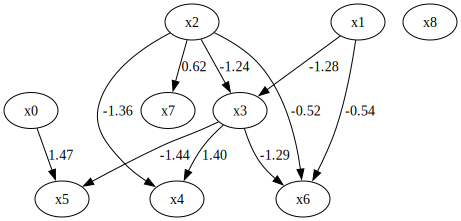

In [227]:
make_dot(Bs_true[1])

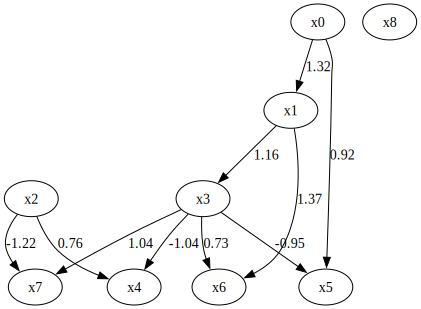

In [228]:
make_dot(Bs_true[0])